HAR ANVÄNT MIG AV PREPROCESSING FRÅN samma fil som förra:

https://www.kaggle.com/code/amrabdellatif/brain-tumor-image-dataset-pytorch



och UNET från:

https://www.kaggle.com/code/wilbertch/mri-image-segmentation-unet




Andra att UNET undersöka som inte undersöks i denna notebook men som vi kan kolla på:

https://www.kaggle.com/code/moemnelhalose/brain-tumor-u-net-98

https://www.kaggle.com/code/nithunith/brain-tumor-unet



In [ ]:
import os 
import glob
import json
import numpy as np
import cv2

In [2]:
train_path = "train"
valid_path = "valid"

In [3]:
train_data=[image for image in os.listdir(train_path)]


In [4]:
# creating mask from annotations
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
#     print(mask_np.shape)

    # Counter for the object number
    object_number = 1

    printed_masks = 0  # Counter for the number of printed masks

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
#             print(f"Processing annotation for image {image_info['file_name']}: {ann}")
            # Extract segmentation polygon
            for seg_idx, seg in enumerate(ann['segmentation']):
#                 print(f"Segmentation points: {seg}")
                # Convert polygons to a binary mask and add it to the main mask
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                # Create a mask for each segmentation
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  # Set the pixel values to 255 for the polygon
                # Save the segmentation mask
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
#                 print(f"Saved segmentation mask for {image_info['file_name']} segment {seg_idx} to {mask_path}")
                
                # Print the segmentation mask using imshow
                # plt.imshow(seg_mask, cmap='gray')
                # plt.title(f"Segmentation Mask for {image_info['file_name']} Segment {seg_idx}")
                # plt.show()
                
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached

#     print("All segmentation masks saved.")

In [5]:
# main function to create datasets
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
    
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)
#         print(f"Copied original image to {new_image_path}")

In [6]:
# ONLY NEEDED ONCE: Calling main function to create datasets 

# original_image_dir = 'test'  # Where your original images are stored
# json_file = 'test/_annotations.coco.json'
# mask_output_folder = 'test2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
# image_output_folder = 'test2/images'  # 
# main(json_file, mask_output_folder, image_output_folder, original_image_dir)


# original_image_dir = 'train'  # Where your original images are stored
# json_file = 'train/_annotations.coco.json'
# mask_output_folder = 'train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
# image_output_folder = 'train2/images'  # 
# main(json_file, mask_output_folder, image_output_folder, original_image_dir)

# original_image_dir = 'valid'  # Where your original images are stored
# json_file = 'valid/_annotations.coco.json'
# mask_output_folder = 'valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
# image_output_folder = 'valid2/images'  # 
# main(json_file, mask_output_folder, image_output_folder, original_image_dir)

"I found a problem within train dataset .. there's an image that doesnt have a corresponding mask so im making a function to search and grab that file and delete it"

In [7]:
# import os

# def compare_folders_and_delete(folder1_path, folder2_path):
#     folder1_items = os.listdir(folder1_path)
#     folder2_items = os.listdir(folder2_path)

#     for item1 in folder1_items:
#         found = False
#         for item2 in folder2_items:
#             if item1[:4] == item2[:4]:
#                 found = True
#                 break
#         if not found:
#             print(f"Corresponding item for {item1} not found.")
#             item1_path = os.path.join(folder1_path, item1)
#             os.remove(item1_path)
#             print(f"Deleted {item1}")

#     for item2 in folder2_items:
#         found = False
#         for item1 in folder1_items:
#             if item2[:4] == item1[:4]:
#                 found = True
#                 break
#         if not found:
#             print(f"Corresponding item for {item2} not found.")
#             item2_path = os.path.join(folder2_path, item2)
#             os.remove(item2_path)
#             print(f"Deleted {item2}")

# # Example usage:
# folder1_path = "train2/images"
# folder2_path = "train2/masks"
# compare_folders_and_delete(folder1_path, folder2_path)

In [12]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "train2" 
valid_path = "valid2"
test_path = "test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Create datasets
train_dataset = CustomDataset_general(train_path, transform=image_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform)
# test_dataset = CustomDataset_general(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([32, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [14]:
# lets take a look at the data inside dataloaders and make sure it within range of [0,1] 

# Assuming x is a tensor from your DataLoader
# x, y = next(iter(train_loader))
import torch
# Count number of ones and zeros in tensor x
num_ones = torch.eq(x, 1).sum().item()
num_zeros = x.numel() - num_ones

print("Number of ones in x:", num_ones)
print("Number of zeros in x:", num_zeros)

# Count number of ones and zeros in tensor y
num_ones = torch.eq(y, 1).sum().item()
num_zeros = y.numel() - num_ones

print("Number of ones in y:", num_ones)
print("Number of zeros in y:", num_zeros)

Number of ones in x: 59273
Number of zeros in x: 1546359
Number of ones in y: 51260
Number of zeros in y: 1554372


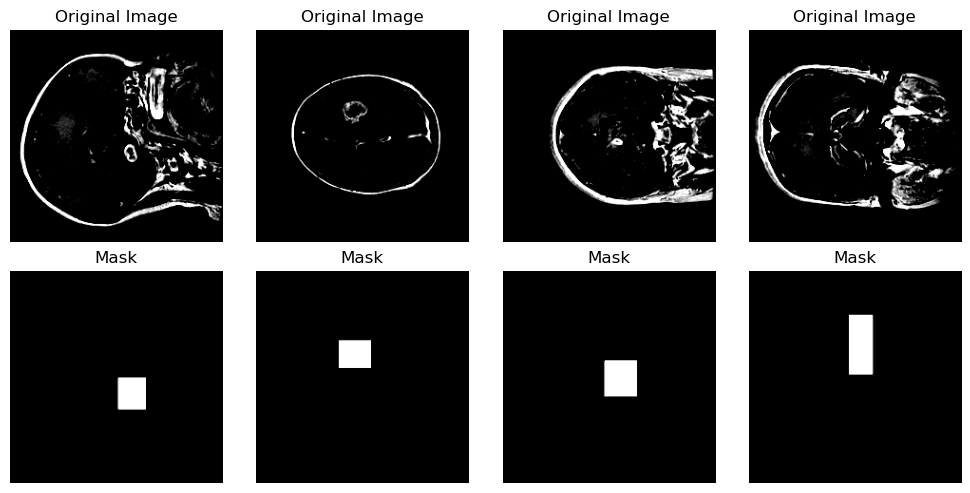

In [15]:
# plotting images
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays and squeeze the channel dimension
x_np = x.numpy().squeeze(1)
y_np = y.numpy().squeeze(1)

# Plot the images
plt.figure(figsize=(10, 5))

# Plot original images
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_np[i], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

# Plot masks
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.imshow(y_np[i], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

HÄRIFRÅN OCH NER ÄR TAGET FRÅN https://www.kaggle.com/code/wilbertch/mri-image-segmentation-unet // Richard

In [17]:
import torch
from torchvision import datasets
from torchmetrics.classification import JaccardIndex
from torch.utils.data import Dataset ,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler

UNET VERKAR ANVÄNDA DICE LOSS SOM ÄR NGN FÖRBÄTTRING AV crossentropy loss https://cvinvolution.medium.com/dice-loss-in-medical-image-segmentation-d0e476eb486

In [25]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        smooth = 1.0
        y_pred = y_pred.reshape(-1)
        y_true = y_true.reshape(-1)
        intersection = (y_pred * y_true).sum()
        
        dic_loss = 1 - (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
        return dic_loss

In [31]:
!pip install torchsummary

In [33]:
import segmentation_models_pytorch as smp
import torchsummary


ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1, 
    classes=1, 
    activation=ACTIVATION,
)
model.to(DEVICE)
print(torchsummary.summary(model, (1, 224, 224)))


# funkar men ger väldigt sparse model summary med pytorch_model_summary
# import segmentation_models_pytorch as smp
# import pytorch_model_summary 


# ENCODER = 'efficientnet-b0'
# ENCODER_WEIGHTS = 'imagenet'
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ACTIVATION = None
# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     in_channels=1, 
#     classes=1, 
#     activation=ACTIVATION,
# )
# model.to(DEVICE)
# print(pytorch_model_summary.summary(model, torch.zeros((1, 1, 224, 224)).to(DEVICE), show_input=True))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             288
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

KAN BEHÖVA ÄNDAR DATALOADERS SÅ ATT DOM LÄGGS PÅ GPU OCH GREJER OM VI VILL GÖRA SAKER PÅ GPU...? CTRL + F PÅ "cuda" I TYP HA2 PART1 

In [39]:
# params
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE =1e-3

checkpoints_path = "exp/checkpoints.pth"
os.makedirs("exp", exist_ok=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = DiceLoss()


In [40]:
from tqdm import tqdm
def train(model,optimizer,loss_fn,loader,device):
    epoch_loss =0.0
    model.train()
    
    for x,y in tqdm(loader):
        x = x.to(device, dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()
        
    # Put Jaccard index here
    
    return epoch_loss/len(loader)

In [41]:
def valid(model,loader,loss_fn,device):
    epoch_loss = 0.0
    model.eval()
    
    for x,y in loader:
        x = x.to(device, dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        pred = model(x)
        loss = loss_fn(pred,y)
        epoch_loss +=loss.item()
    return epoch_loss/len(loader)

In [42]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses = []
val_losses = []
num_no_improve = 0

model.to(device)  # Move the model to the appropriate device

for epoch in range(NUM_EPOCHS):
    train_loss = train(model,optimizer,loss_fn,train_loader,device) # Train the model
    val_loss = valid(model,valid_loader,loss_fn,device) # Validate the model
    train_losses.append(train_loss) # Save the training loss
    val_losses.append(val_loss)
    
    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Dice Loss: {train_loss:.4f}, Train Dice Similarity Coef: {1-train_loss:.4f}')
    print(f'Validation Dice Loss: {val_loss:.4f}, Validation Dice Similarity Coef: {1-val_loss:.4f}')
    
    if val_loss < best_val_loss: # Save the model with the best validation loss
        best_val_loss = val_loss
        print("Saving the model")
        torch.save(model.state_dict(), checkpoints_path) # Load Best Model Back
    
    if val_loss > best_val_loss:
        best_dict = torch.load(checkpoints_path)
        print('Loading Best Model')
        model.load_state_dict(best_dict)
    
    # Check for early stopping, If the validation loss does not improve for 5 consecutive epochs, stop the training
    if len(train_losses) > 1: 
        if val_loss <= best_val_loss: 
            num_no_improve += 1
        else:
            num_no_improve = 0
            
    if num_no_improve >= 5:
        print("Early stopping")
        break
        
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show(block=False)

Epoch 1/10, Train Dice Loss: 0.7688, Train Dice Similarity Coef: 0.2312
Validation Dice Loss: 0.7365, Validation Dice Similarity Coef: 0.2635
Saving the model


  0%|                                                   | 0/47 [00:10<?, ?it/s]


KeyboardInterrupt: 

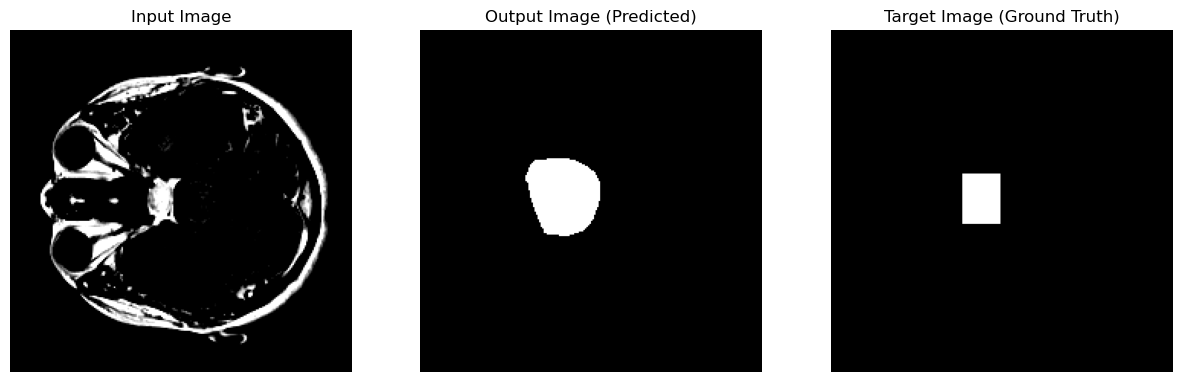

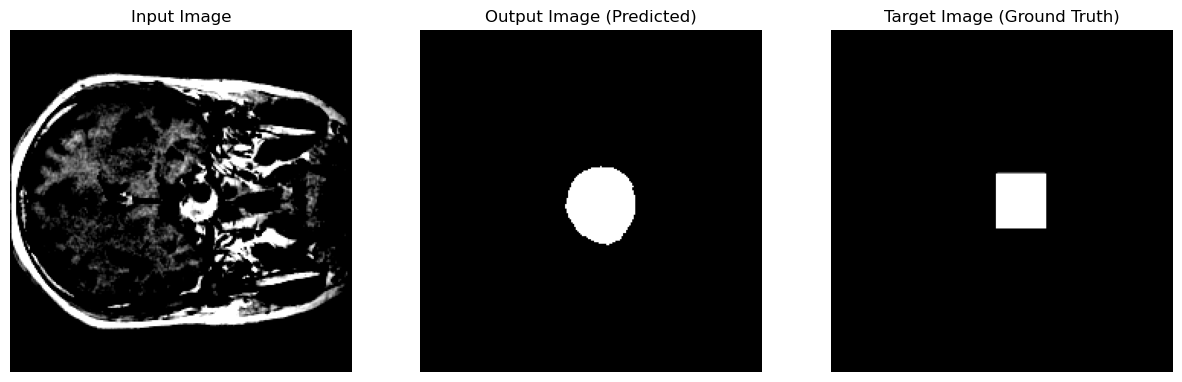

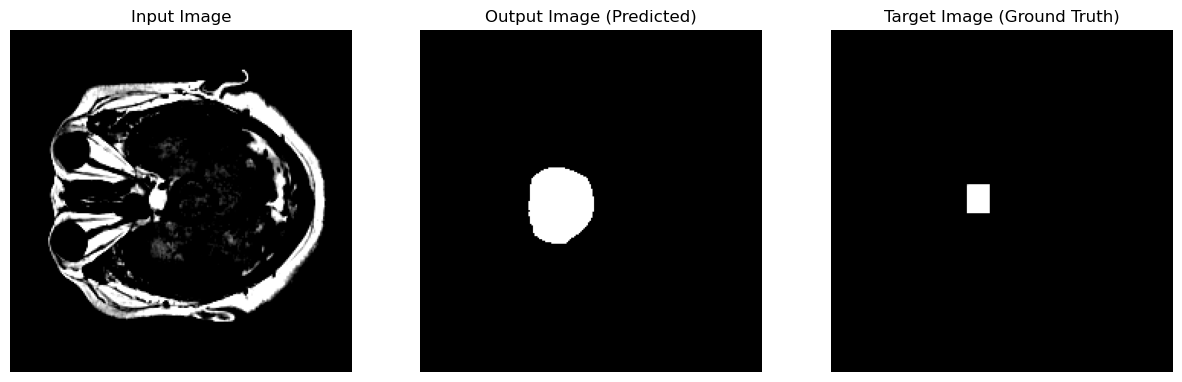

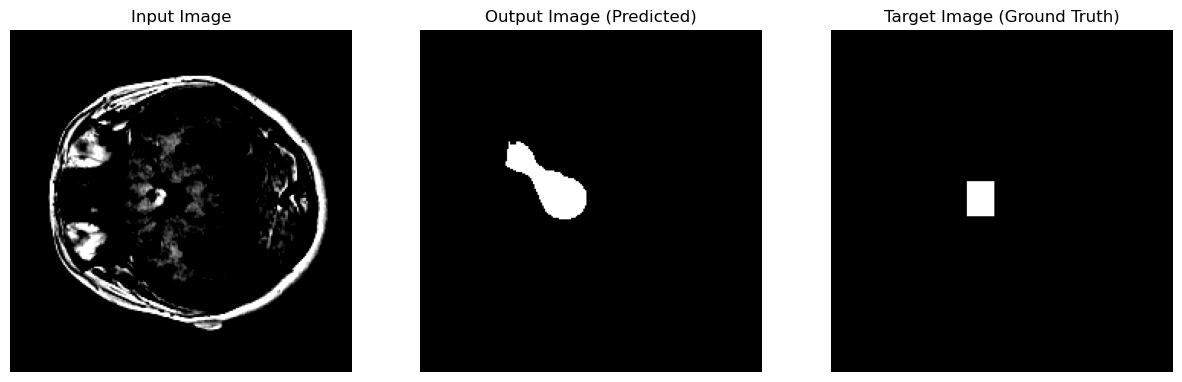

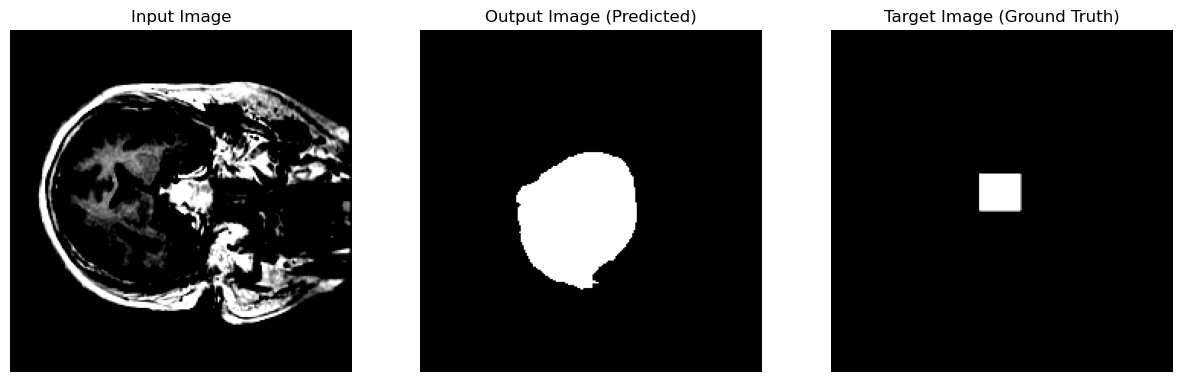

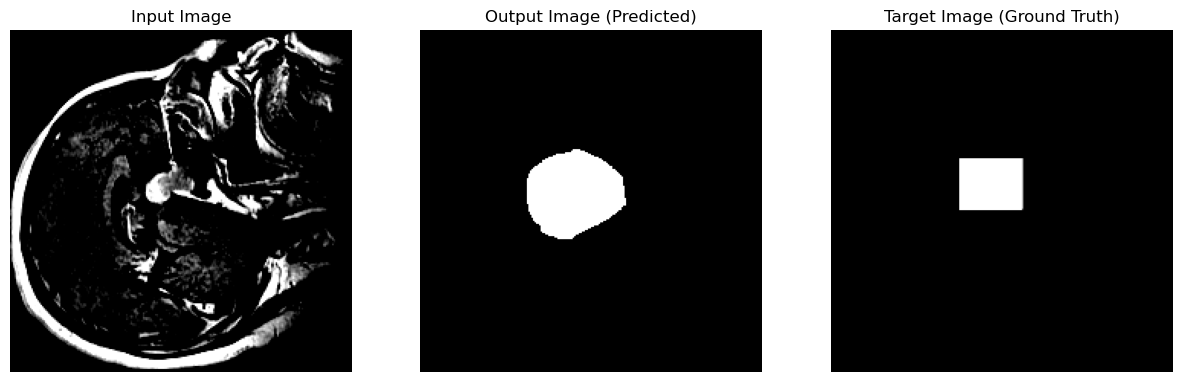

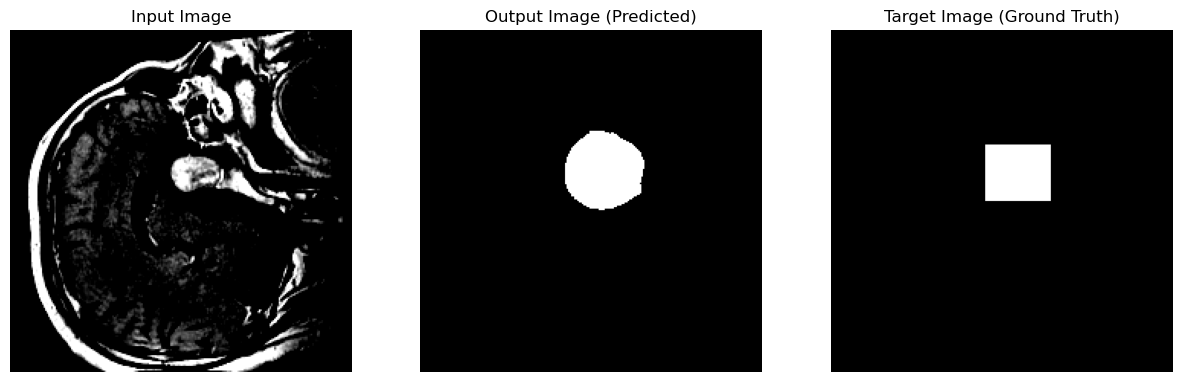

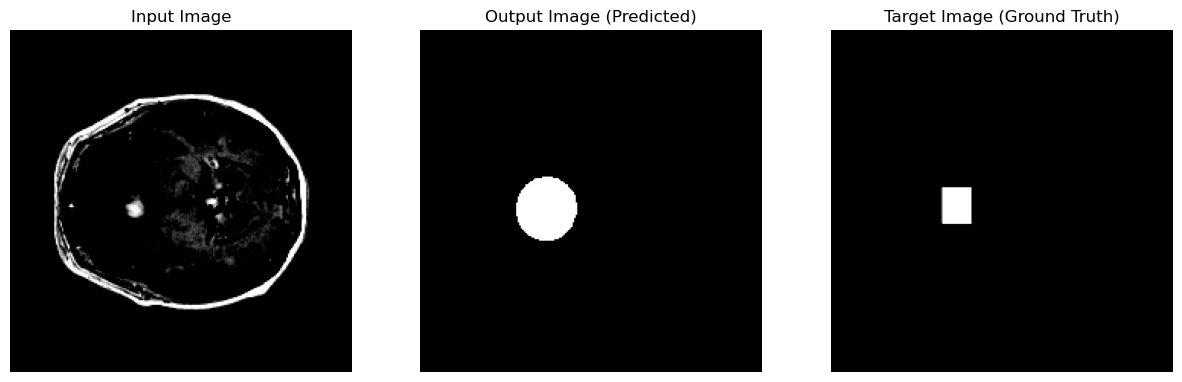

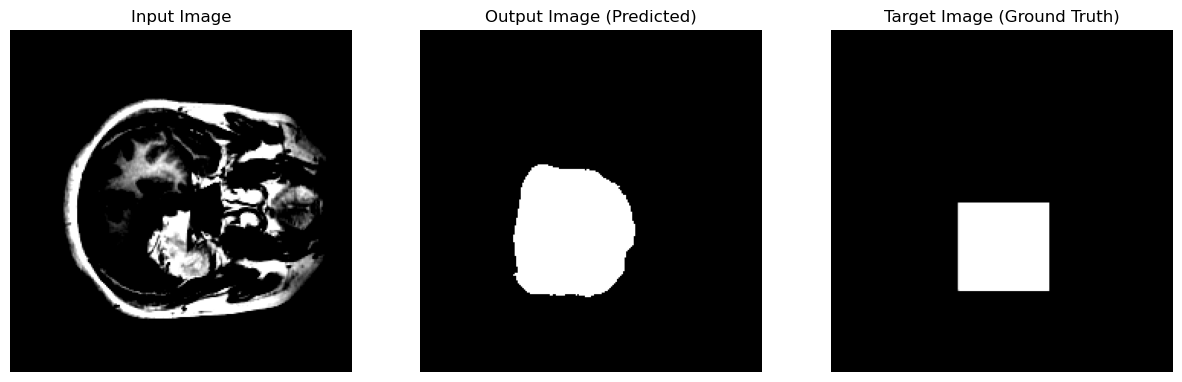

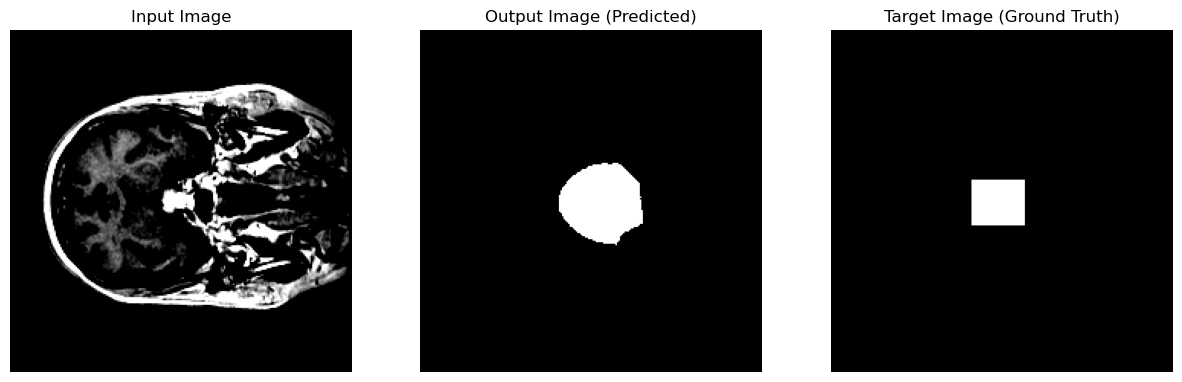

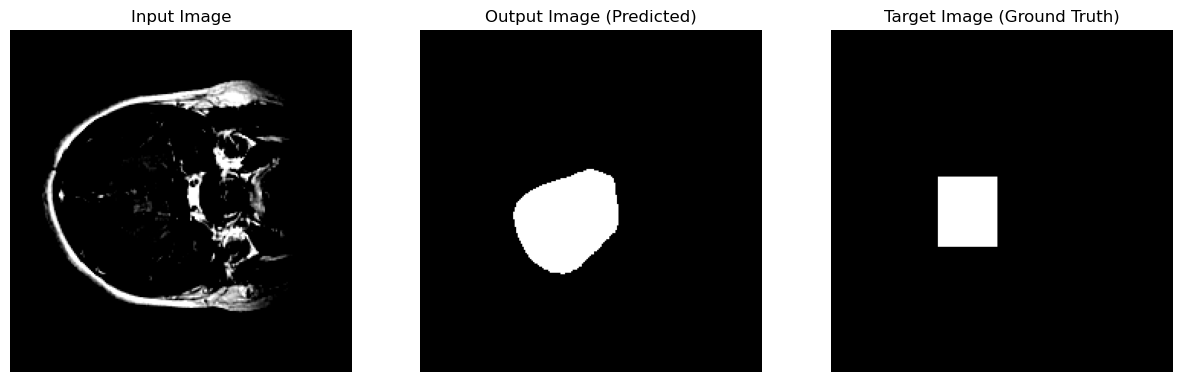

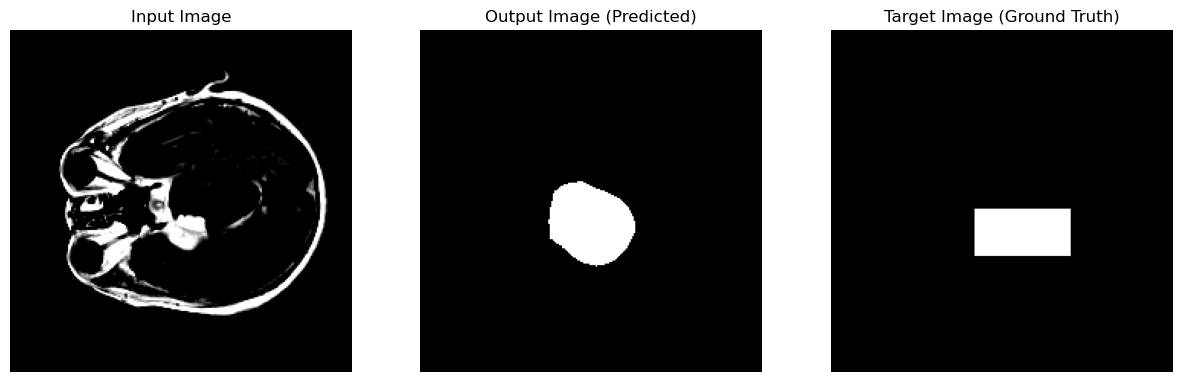

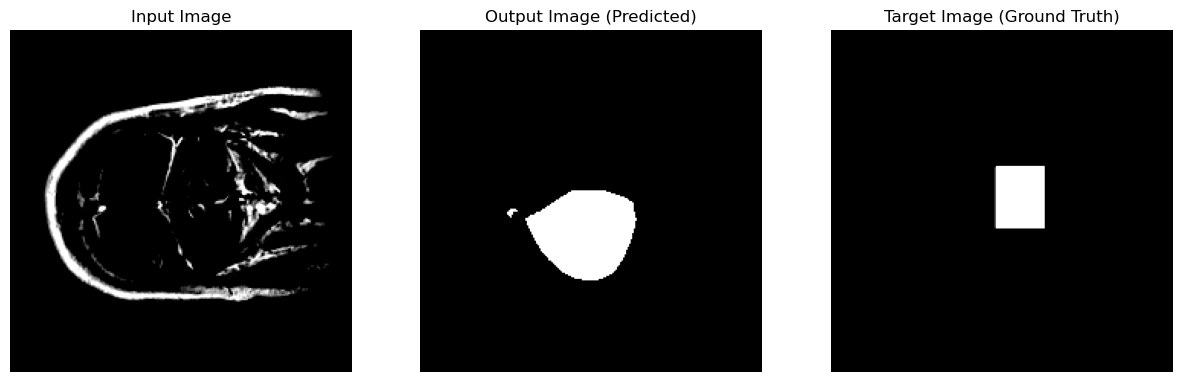

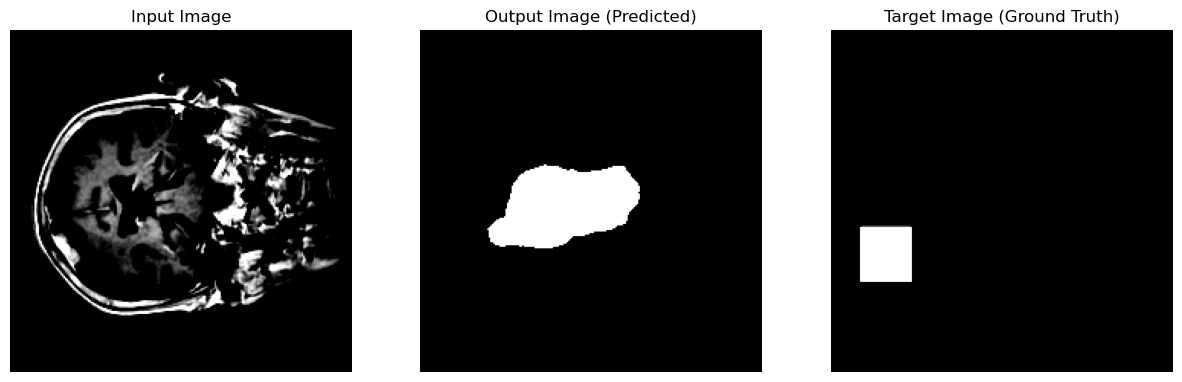

In [43]:
def visualize_input_output_target(input_image, output_image, target_image):
    # Move tensors to CPU memory if they are on CUDA devices
    input_image = input_image.cpu()
    output_image = output_image.cpu()
    target_image = target_image.cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot input image
    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Plot output image (predicted binary mask)
    axes[1].imshow(output_image.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    # Plot target image (ground truth binary mask)
    axes[2].imshow(target_image.squeeze().numpy(), cmap='gray')
    axes[2].set_title('Target Image (Ground Truth)')
    axes[2].axis('off')

    plt.show()
    fig.savefig("output.png")

with torch.inference_mode():
    for batch, (X, y) in enumerate(valid_loader):
        X = X.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)

        y_pred_logits = model(X)
        
        # Assuming y_pred_logits contains probabilities or logits for each pixel
        # You may need to apply thresholding or other post-processing to get binary images
        # Here, we'll just consider values above 0.5 as foreground (1) and below as background (0)
        y_pred_binary = (y_pred_logits > 0.5).float()

        # Visualize input, output, and target binary images for the first batch
        visualize_input_output_target(X[0], y_pred_binary[0], y[0])